# PREPARACION DE DATOS

En esta fase se van a crear nuevas variables o transformar las existentes para poder dar mejor respuesta al objetivo.

## SET UP

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlalchemy as sa
%config IPCompleter.greedy = True

## CARGA DE DATOS

In [39]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')
df = pd.read_sql('df', con = con)
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,...,t,2,1.0,1.0,80,4.87,4.89,4.77,5098,Chamartín
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,...,f,1,1.0,1.0,33,4.58,4.82,4.21,2267,Latina
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,...,f,6,3.0,5.0,0,NaN,NaN,NaN,4085,Arganzuela
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,...,f,3,1.0,1.0,12,4.92,5.00,5.00,4827,Centro
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,...,f,1,1.0,1.0,149,4.68,4.71,4.70,4085,Arganzuela


## PREPARACION DE VARIABLES

### Creacion de kpis de palancas

Primero se van a crear las variables de análisis, es decir las que se habian identificado como los Kpis que se usaran en las palancas que influyen sobre el negocio.

Se habia dicho que eran 3:

* precio por noche: esta está directamente en la variable price, pero será revisada
* ocupación: está availability_365 pero hay que transformarla
* precio del inmueble: habrá que crearla con variables externas así que la dejamos para después

**Empezamos con el precio.**

Es un dato clave para poder hacer la valoración de los potenciales ingresos de un inmueble.

Se analiza el precio medio por tipo de alquiler.

Es importante filtrar por solo un distrito para no incluir el efecto "zona".

Así que primero se elige un distrito que tenga muchos datos.

In [40]:
df.distrito.value_counts()

distrito
Centro                   8127
Salamanca                1218
Chamberí                 1089
Arganzuela               1005
Tetuán                    762
Retiro                    618
Carabanchel               581
Chamartín                 538
Ciudad Lineal             532
Moncloa - Aravaca         493
Puente de Vallecas        465
San Blas - Canillejas     463
Latina                    455
Hortaleza                 354
Fuencarral - El Pardo     265
Usera                     233
Barajas                   142
Villaverde                129
Moratalaz                  94
Villa de Vallecas          90
Vicálvaro                  57
Name: count, dtype: int64

In [41]:
df.loc[df.distrito == 'Centro',:].groupby('room_type').price.describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,5992.0,148.859980,482.106713,20.0,63.00,86.0,126.00,9999.0
Private room,2051.0,67.131643,113.118208,20.0,29.00,40.0,59.00,2500.0
Shared room,84.0,60.464286,112.647274,20.0,21.75,26.5,39.25,700.0


In [42]:
df.loc[df.distrito == 'Centro',:].groupby('room_type').price.mean()

room_type
Entire home/apt    148.859980
Private room        67.131643
Shared room         60.464286
Name: price, dtype: float64

Conclusión:
    
* alquilar el apartamento tiene un precio medio de 148€
* alquilar una habitación tiene un precio medio de 60€ o 67€ según sea compartida o privada
* por tanto para calcular los "ingresos" de un inmueble se deberá multiplicar el precio el precio por el número de habitaciones cuando sea de los tipos Private room o Shared room

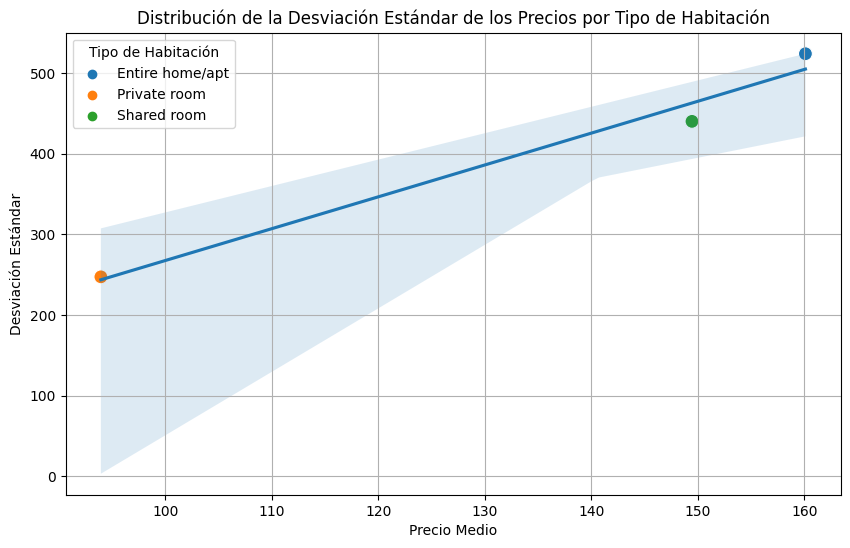

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular los precios medios y las desviaciones estándar correspondientes
mean_prices = df.groupby('room_type')['price'].mean()
std_devs = df.groupby('room_type')['price'].std()

# Crear el scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=mean_prices, y=std_devs, hue=std_devs.index, s=100)

# Añadir la línea de regresión lineal
sns.regplot(x=mean_prices, y=std_devs, scatter=False)

# Etiquetas y título
plt.xlabel('Precio Medio')
plt.ylabel('Desviación Estándar')
plt.title('Distribución de la Desviación Estándar de los Precios por Tipo de Habitación')

# Mostrar el gráfico
plt.legend(title='Tipo de Habitación', loc='upper left')
plt.grid(True)
plt.show()


Ahora bien, multiplicar el precio por el total de habitaciones puede sesgar artificialmente al alza la capacidad de generar ingresos de un inmueble.

Ya que si se alquila por habitaciones no es probable que siempre esté al 100%

Por tanto se deberá ponderar por el porcentaje medio de habitaciones alquiladas.

No se tiene ese dato, pero supongamos que hemos hablado con el responsable de negocio y nos ha dicho que es del 70%.

Se crea la variable precio total aplicando apply sobre una función personalizada.

In [44]:
def crear_precio_total(registro):
    if (registro.bedrooms > 1) & (registro.room_type == 'Private room'):
        salida = registro.bedrooms * registro.price * 0.7
    else:
        salida = registro.price
    return (salida)

df['precio_total'] = df.apply(crear_precio_total, axis = 1)

In [45]:
df.loc[df.room_type == 'Shared room',:].bedrooms.value_counts()

bedrooms
1.0    175
Name: count, dtype: int64

In [46]:
df[['room_type', 'price', 'bedrooms', 'beds', 'precio_total']].head(30)

,room_type,price,bedrooms,beds,precio_total
0,Private room,60,1.0,1.0,60.0
1,Private room,31,1.0,1.0,31.0
2,Entire home/apt,50,3.0,5.0,50.0
3,Entire home/apt,92,1.0,1.0,92.0
4,Private room,26,1.0,1.0,26.0
5,Entire home/apt,85,3.0,3.0,85.0
6,Entire home/apt,65,1.0,2.0,65.0
7,Entire home/apt,54,1.0,1.0,54.0
8,Entire home/apt,1400,2.0,3.0,1400.0
9,Entire home/apt,81,1.0,2.0,81.0


In [47]:
#esto se hace para ver si los tipo de habitaciones privadas, que tienen 2 o mas camas, aplican bien el finxion 
df.query('room_type == "Private room" and bedrooms>= 2')

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito,precio_total
58,58,219303,*** Malasaña B&B exterior***,499977,Centro,Universidad,40.423770,-3.702410,Private room,21,...,3,3.0,2.0,188,4.35,4.62,4.83,4827,Centro,44.1
93,93,345230,GOYA apartment.Heart of Madrid,1095831,Centro,Universidad,40.425310,-3.705970,Private room,77,...,2,2.0,2.0,4,4.33,5.00,4.67,4827,Centro,107.8
149,149,510973,Habitación céntrica a 1 min de Plza Santa Ana,2517520,Centro,Cortes,40.414120,-3.700570,Private room,46,...,1,3.0,3.0,4,5.00,4.75,5.00,4827,Centro,96.6
173,173,570158,Stanza- Carina,2347489,Tetuán,Cuatro Caminos,40.447000,-3.702910,Private room,20,...,1,2.0,0.0,35,4.58,4.59,4.76,3678,Tetuán,28.0
199,199,659887,Habitación amplia y comoda centro Madrid,3329487,Retiro,Pacífico,40.402640,-3.683090,Private room,29,...,2,2.0,4.0,5,4.50,4.75,5.00,4788,Retiro,40.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17237,17237,51437619,Bright room in Madrid Downtown with host.,29223251,Centro,Embajadores,40.409820,-3.700240,Private room,49,...,2,2.0,1.0,0,NaN,NaN,NaN,4827,Centro,68.6
17251,17251,51449614,ALOJAMIENTO VACACIONAL,127791021,Moncloa - Aravaca,Argüelles,40.430380,-3.717050,Private room,35,...,2,3.0,1.0,1,5.00,5.00,5.00,4033,Moncloa - Aravaca,73.5
17318,17318,51573953,Lovely room in Madrid centre - Gay friendly.,391778303,Centro,Justicia,40.425508,-3.697632,Private room,32,...,1,2.0,1.0,0,NaN,NaN,NaN,4827,Centro,44.8
17668,17668,52139488,Habitaciones baño compartido La Vaguada,421862905,Fuencarral - El Pardo,Pilar,40.480700,-3.711420,Private room,25,...,10,3.0,5.0,0,NaN,NaN,NaN,3568,Fuencarral - El Pardo,52.5


**Ocupación**

La variable que permite medir esto es availability_365.

Esta variable dice el número de días a un año vista que el inmueble NO está ocupado.

Por tanto interesaría transformarla a una medida más directa de ocupación, por ejemplo el % del año que SI está ocupada.

Podemos hacerlo con una tranformación directa.

In [48]:
df.availability_365.head()

0    180
1    364
2    222
3    115
4    349
Name: availability_365, dtype: int64

In [49]:
df['ocupacion_%'] = (((365 - df.availability_365)/365)*100).astype('int64')

### Transformación de varaibles de análisis

Algunas de las preguntas semilla están dirigidas a comprobar cómo se comporta el precio o la ocupación según otras variables como el número de habitaciones, la media de valoraciones, etc.

Normalmente se puede hacer mejor estos análisis si se discretiza la variable de análisis.

Bedrooms tiene sentido una discretización más personalizada. En las otras se puede hacer automática.

**Discretizar bedrooms**

Se comienza por evaluar la distribución de los datos.

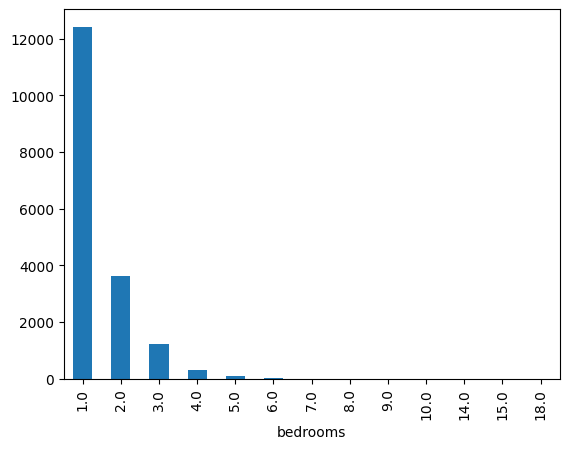

In [50]:
df.bedrooms.value_counts().plot.bar();

Se discretiza para 1,2,3 y más de 3.

Se puede usar np.select

In [51]:
condiciones = [df.bedrooms == 1,
                df.bedrooms == 2,
                df.bedrooms == 3,
                df.bedrooms > 3]

resultados = ['01_Una', '02_Dos', '03_Tres', '04_Cuatro_o_mas']

df['bedrooms_discretizada'] = np.select(condiciones, resultados, default=-999)

In [52]:
df.bedrooms_discretizada.value_counts()

bedrooms_discretizada
01_Una             12422
02_Dos              3617
03_Tres             1228
04_Cuatro_o_mas      443
Name: count, dtype: int64

**Discretizar accommodates, beds y number_of_reviews**

Se va a usar qcut para discritizar con percentiles 0.5, 0.8, 1

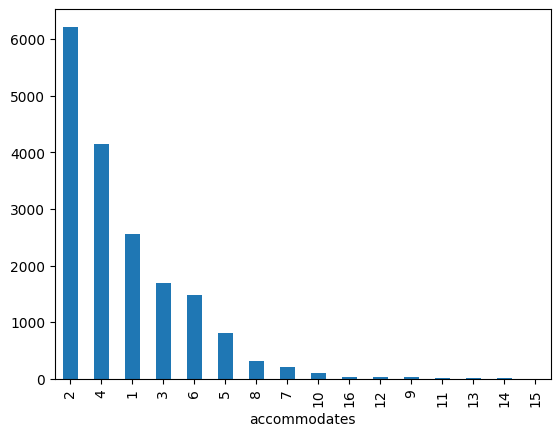

In [53]:
df.accommodates.value_counts().plot.bar();

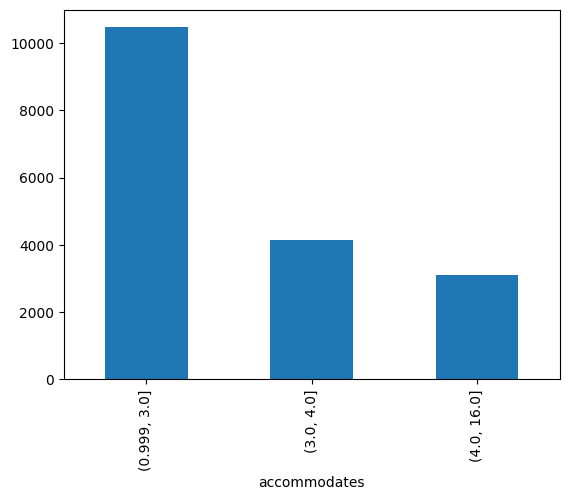

In [54]:
pd.qcut(df.accommodates, [0,0.5,0.8,1]).value_counts().plot.bar();

In [55]:
df['accommodates_disc'] = pd.qcut(df.accommodates, [0,0.5,0.8,1], labels=['0-3', '4', '5-16'])

In [56]:
pd.qcut(df.beds, [0,0.5,0.8,1]).value_counts()

beds
(-0.001, 2.0]    13394
(2.0, 3.0]        2249
(3.0, 24.0]       2067
Name: count, dtype: int64

In [57]:
#ahora paso a disctretizar la variable beds
df['beds_disc'] = pd.qcut(df.beds, [0,0.5,0.8,1], labels=['1', '2', '3-23'])

In [58]:
df

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito,precio_total,ocupacion_%,bedrooms_discretizada,accommodates_disc,beds_disc
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,60,...,4.87,4.89,4.77,5098,Chamartín,60.0,50,01_Una,0-3,1
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31,...,4.58,4.82,4.21,2267,Latina,31.0,0,01_Una,0-3,1
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.388400,-3.695110,Entire home/apt,50,...,NaN,NaN,NaN,4085,Arganzuela,50.0,39,03_Tres,5-16,3-23
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,92,...,4.92,5.00,5.00,4827,Centro,92.0,68,01_Una,0-3,1
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,26,...,4.68,4.71,4.70,4085,Arganzuela,26.0,4,01_Una,0-3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17705,17705,52182264,Enormous Private Room in 12-Bedroom Unit - los...,378060726,Centro,Justicia,40.424384,-3.691216,Private room,29,...,NaN,NaN,NaN,4827,Centro,29.0,1,01_Una,0-3,1
17706,17706,52182273,Stunning Private Room in 11-Bedroom Unit - los...,378060726,Centro,Justicia,40.424447,-3.691309,Private room,29,...,NaN,NaN,NaN,4827,Centro,29.0,1,01_Una,0-3,1
17707,17707,52182303,Classic Private Room in 7-Bedroom Unit - los 3...,378060726,Centro,Justicia,40.424989,-3.691783,Private room,29,...,NaN,NaN,NaN,4827,Centro,29.0,1,01_Una,0-3,1
17708,17708,52182321,Elegant Private Room in 12-Bedroom Unit - los ...,378060726,Salamanca,Recoletos,40.424352,-3.690211,Private room,29,...,NaN,NaN,NaN,6114,Salamanca,29.0,1,01_Una,0-3,1


In [59]:
pd.qcut(df.number_of_reviews, [0,0.5,0.8,1]).value_counts()

number_of_reviews
(-0.001, 5.0]    8871
(5.0, 49.0]      5304
(49.0, 744.0]    3535
Name: count, dtype: int64

In [60]:
df['reviews_disc'] = pd.qcut(df.number_of_reviews, [0,0.5,0.8,1], labels=['1-4', '5-48', '49-743'])

In [61]:
df

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,review_scores_communication,review_scores_location,precio_m2,distrito,precio_total,ocupacion_%,bedrooms_discretizada,accommodates_disc,beds_disc,reviews_disc
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,60,...,4.89,4.77,5098,Chamartín,60.0,50,01_Una,0-3,1,49-743
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31,...,4.82,4.21,2267,Latina,31.0,0,01_Una,0-3,1,5-48
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.388400,-3.695110,Entire home/apt,50,...,NaN,NaN,4085,Arganzuela,50.0,39,03_Tres,5-16,3-23,1-4
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,92,...,5.00,5.00,4827,Centro,92.0,68,01_Una,0-3,1,5-48
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,26,...,4.71,4.70,4085,Arganzuela,26.0,4,01_Una,0-3,1,49-743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17705,17705,52182264,Enormous Private Room in 12-Bedroom Unit - los...,378060726,Centro,Justicia,40.424384,-3.691216,Private room,29,...,NaN,NaN,4827,Centro,29.0,1,01_Una,0-3,1,1-4
17706,17706,52182273,Stunning Private Room in 11-Bedroom Unit - los...,378060726,Centro,Justicia,40.424447,-3.691309,Private room,29,...,NaN,NaN,4827,Centro,29.0,1,01_Una,0-3,1,1-4
17707,17707,52182303,Classic Private Room in 7-Bedroom Unit - los 3...,378060726,Centro,Justicia,40.424989,-3.691783,Private room,29,...,NaN,NaN,4827,Centro,29.0,1,01_Una,0-3,1,1-4
17708,17708,52182321,Elegant Private Room in 12-Bedroom Unit - los ...,378060726,Salamanca,Recoletos,40.424352,-3.690211,Private room,29,...,NaN,NaN,6114,Salamanca,29.0,1,01_Una,0-3,1,1-4


### Creación de variables con datos externos

En este caso en concreto se podrían hacer muchas cosas con datos externos.

Lo primero, que ya hemos incorporado parcialmente, es la palanca del precio del inmueble.

Decíamos que la podíamos estimar multiplicando los metros cuadrados del inmueble por el precio por m2.

El precio_m2 ya lo hemos conseguido, pero el tamaño del inmueble no lo tenemos en los datos.

Lo que podemos hacer es establecer unos criterios en base al número de habitaciones.

No es perfecto, pero servirá de aproximación.

**Estimación de los metros cuadrados del inmueble**

Vamos usar el siguiente algoritmo:

* una habitación: m2 = 50
* dos habitaciones: m2 = 70
* tres habitaciones: m2 = 90
* cuatro habitaciones: m2 = 120
* cinco o más habitaciones: m2 = 150

In [62]:
criterios = [df.bedrooms == 1,
             df.bedrooms == 2,
             df.bedrooms == 3,
             df.bedrooms == 4,
             df.bedrooms > 4]

resultados = [50, 70, 90, 120, 150]

df['metros_2'] = np.select(criterios, resultados, default=-999)

In [63]:
df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,review_scores_location,precio_m2,distrito,precio_total,ocupacion_%,bedrooms_discretizada,accommodates_disc,beds_disc,reviews_disc,metros_2
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,60,...,4.77,5098,Chamartín,60.0,50,01_Una,0-3,1,49-743,50
1,1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,...,4.21,2267,Latina,31.0,0,01_Una,0-3,1,5-48,50
2,2,23001,Apartmento Arganzuela- Madrid Rio,82175,Arganzuela,Legazpi,40.38840,-3.69511,Entire home/apt,50,...,NaN,4085,Arganzuela,50.0,39,03_Tres,5-16,3-23,1-4,90
3,3,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,...,5.00,4827,Centro,92.0,68,01_Una,0-3,1,5-48,50
4,4,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,26,...,4.70,4085,Arganzuela,26.0,4,01_Una,0-3,1,49-743,50


In [64]:
df.query('bedrooms > 4')[['bedrooms', 'metros_2']]

,bedrooms,metros_2
160,5.0,150
339,5.0,150
568,7.0,150
725,5.0,150
1058,5.0,150
...,...,...
16801,6.0,150
16811,6.0,150
16891,5.0,150
16919,6.0,150


In [65]:
df.metros_2.value_counts()

metros_2
50     12422
70      3617
90      1228
120      296
150      147
Name: count, dtype: int64

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17710 entries, 0 to 17709
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   index                           17710 non-null  int64   
 1   id                              17710 non-null  int64   
 2   name                            17707 non-null  object  
 3   host_id                         17710 non-null  int64   
 4   neighbourhood_group             17710 non-null  object  
 5   neighbourhood                   17710 non-null  object  
 6   latitude                        17710 non-null  float64 
 7   longitude                       17710 non-null  float64 
 8   room_type                       17710 non-null  object  
 9   price                           17710 non-null  int64   
 10  minimum_nights                  17710 non-null  int64   
 11  calculated_host_listings_count  17710 non-null  int64   
 12  availability_365  

In [68]:
df.precio_m2

0        5098
1        2267
2        4085
3        4827
4        4085
         ... 
17705    4827
17706    4827
17707    4827
17708    6114
17709    4827
Name: precio_m2, Length: 17710, dtype: int64

In [69]:
df['precio_compra'] = (df.metros_2 * df.precio_m2) * 0.7

In [71]:
df.precio_compra

0        178430.0
1         79345.0
2        257355.0
3        168945.0
4        142975.0
           ...   
17705    168945.0
17706    168945.0
17707    168945.0
17708    213990.0
17709    168945.0
Name: precio_compra, Length: 17710, dtype: float64

In [72]:
df[['bedrooms', 'metros_2', 'distrito', 'precio_m2', 'precio_compra']]

,bedrooms,metros_2,distrito,precio_m2,precio_compra
0,1.0,50,Chamartín,5098,178430.0
1,1.0,50,Latina,2267,79345.0
2,3.0,90,Arganzuela,4085,257355.0
3,1.0,50,Centro,4827,168945.0
4,1.0,50,Arganzuela,4085,142975.0
...,...,...,...,...,...
17705,1.0,50,Centro,4827,168945.0
17706,1.0,50,Centro,4827,168945.0
17707,1.0,50,Centro,4827,168945.0
17708,1.0,50,Salamanca,6114,213990.0


Ya que en turismo la localización es muy importante.

Por ejemplo podríamos calcular las distancias a diferentes puntos de interés como monumentos, lugares de ocio, recintos deportivos, etc.

En este caso se calcula la distancia a Puerta del Sol en España.

Para ello buscamos en Google su longitud y latitud: https://www.123coordenadas.com/coordinates/81497-puerta-del-sol-madrid

Latitud: 40.4167278 Longitud: -3.7033387

**Cálculo de la distancia de cada inmueble a la Puerta del Sol**

Dada la curvatura de la tierra la distancia entre dos puntos a partir de su latitud y longitud se calcula con una fórmula que se llama distancia de Haversine.

Una búsqueda en Google nos da una función ya construída para calcularla que podemos adaptar: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [74]:
#a modo de completar el df y aprovechar datos como la latitud y longitud. calculo la distancia de cada departamento con la puerta del sol de madrid
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

In [75]:
#Las coordenadas de la Puerta del Sol serán lat1 y lon1
lat1 = 40.4167278
lon1 = -3.7033387

df['pdi_sol'] = df.apply(lambda registro: haversine(lat1,lon1,registro.latitude,registro.longitude),axis = 1)

Se comprueba revisando la distancia media por distritos. (Puerta del Sol queda en distrito Centro)

In [76]:
df.groupby('distrito').pdi_sol.mean().sort_values()

distrito
Centro                    0.730611
Arganzuela                1.939114
Chamberí                  2.133167
Retiro                    2.450593
Salamanca                 2.715975
Moncloa - Aravaca         3.294526
Usera                     3.928874
Latina                    3.942634
Carabanchel               3.970238
Chamartín                 4.432842
Puente de Vallecas        4.481127
Tetuán                    4.624605
Moratalaz                 5.073901
Ciudad Lineal             5.231293
Villaverde                7.664192
Fuencarral - El Pardo     8.062301
Hortaleza                 8.074184
San Blas - Canillejas     8.199011
Vicálvaro                 8.599559
Villa de Vallecas         9.176618
Barajas                  11.439064
Name: pdi_sol, dtype: float64

## GUARDAMOS EN EL DATAMART

In [77]:
df.to_sql('df_preparado', con = con, if_exists='replace')

17710